## 1.0 Introdução

### A Rossmann opera mais de 3.000 drogarias em 7 países europeus. Atualmente, os gerentes de loja da Rossmann têm a tarefa de prever suas vendas diárias com até seis semanas de antecedência. As vendas da loja são influenciadas por muitos fatores, incluindo promoções, concorrência, feriados escolares e estaduais, sazonalidade e localidade. Com milhares de gerentes individuais prevendo vendas com base em suas circunstâncias únicas, a precisão dos resultados pode variar bastante.


#### Dataset Description
Você recebe dados históricos de vendas de 1.115 lojas Rossmann. A tarefa é prever a coluna "Vendas" para o conjunto de teste. Observe que algumas lojas no conjunto de dados foram temporariamente fechadas para reforma.<br/>

Arquivos<br/>
train.csv - Dados históricos incluindo as vendas<br/>
test.csv - Dados históricos sem as vendas<br/>
sample_submission.csv - Uma amostra de submissão do arquivo no formato correto<br/>
store.csv - informações adicionais sobre as lojas<br/>
Campos de dados<br/>
A maioria dos campos é auto-explicativa. A seguir estão as descrições para aqueles que não são:<br/>

- <b>Id</b> - um Id que representa uma duplicata (Store, Date) dentro do conjunto de teste
- <b>Store</b> - um ID exclusivo para cada loja
- <b>Sales</b> - o volume de negócios para um determinado dia (isto é o que você está prevendo)
- <b>Customers</b> - o número de clientes em um determinado dia
- <b>Open</b>- um indicador para saber se a loja estava aberta: 0 = fechado, 1 = aberto
- <b>StateHoliday</b> - indica um feriado estadual. Normalmente todas as lojas, com poucas exceções, fecham nos feriados estaduais. Observe que todas as escolas fecham nos feriados e fins de semana. a = feriado, b = feriado da Páscoa, c = Natal, 0 = nenhum
- <b>SchoolHoliday</b> - indica se o (Store, Date) foi afetado pelo fechamento das escolas públicas
- <b>StoreType</b> - diferencia entre 4 modelos de loja diferentes: a, b, c, d
- <b>Assortment</b> - descreve um nível de sortimento: a = básico, b = extra, c = estendido
- <b>CompetitionDistance</b> - distância em metros até a loja concorrente mais próxima
- <b>CompetitionOpenSince[Month/Year]</b> - fornece o ano e o mês aproximados da hora em que o concorrente mais próximo foi aberto
- <b>Promo</b> - indica se uma loja está realizando uma promoção naquele dia
- <b>Promo2</b> - Promo2 é uma promoção contínua e consecutiva para algumas lojas: 0 = loja não está participando, 1 = loja está participando
- <b>Promo2Since[Year/Week]</b> - descreve o ano e a semana do calendário em que a loja começou a participar do Promo2
- <b>PromoInterval</b> - descreve os intervalos consecutivos em que o Promo2 é iniciado, nomeando os meses em que a promoção é reiniciada. Por exemplo. "Fevereiro, maio, agosto, novembro" significa que cada rodada começa em fevereiro, maio, agosto, novembro de qualquer ano para essa loja
    

Analisando o problema método 4 passos Comunidade DS:

        1. Motivação:
            - A previsão de vendas foi requisitada pelo CFO em uma reunião mensal sobre os resultados das lojas.
        2. Causa Raiz do Problema:
            - Dificuldade em determinar o valor do investimento para Reformas de cada Loja.
        3. Dono do problema:
            - Diretor Financeiro (CFO) da Rossmann
        4. Formato da solução:
            - Granularidade: Previsão de Vendas por dia por Loja  para as próximas 6 semanas;
            - Tipo de problema: Previsão de vendas;
            - Potenciais Métodos: Séries Temporais ou Regressão
            - Formato de Entrega:
                1. Valor total de vendas de cada loja no final de 6 semanas;
                2. Como essas vendas acontecem a cada dia;
                3. Acessar tudo isso pelo celular.



## 2.0 Carregamento dos dados

### Importação das bibliotecas, funções e carregamento dos dados

#### Import Bibliotecas

In [57]:
import pandas as pd
import numpy as np
import math
import inflection
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image
from matplotlib import gridspec
import datetime
from datetime import timedelta

#### Loading Data

In [2]:
df_sales_raw = pd.read_csv('train.csv', low_memory= False)
df_store_raw = pd.read_csv('store.csv', low_memory= False)

# merge datasets
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')
df_raw

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


## 3.0 Descrição dos dados

##### Fazendo uma cópia para caso precise recuperar os dados mais pra frente

In [3]:
df1 = df_raw.copy()

### Rename Columns 
Vamos analisar as colunas do dataset para ver se os nomes são intuitivos e caso precise trocar os nomes a fim de facilitar futuras análises e compreensões das culunas

In [4]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# Rename columns
df1.columns = cols_new
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

### Data Dimensions

In [6]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


### Data Types

In [7]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
print(df1['date'].dtypes)

datetime64[ns]


### Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### Fillout NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

#### competition_distance
- Distância em metros até a loja concorrente mais próxima
- Vamos preencher os valores nulos dessa coluna por um valor muito alto, inferindo que o valor não foi preenchido pelo fato de o concorrente estar muito longe.

In [11]:
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if pd.isnull(x) else x)
df1['competition_distance'].isna().sum()

0

#### competition_open_since_month
- Fornece o mês aproximado do momento em que o concorrente mais próximo foi aberto
- Pensando no feature enginering que será feito mais pra frente, vamos preencher os valores nulos com a data do dia atual de cada linha

In [12]:
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if pd.isnull(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)
df1['competition_open_since_month'].isna().sum()

0

#### competition_open_since_year 
- Fornece o ano aproximado do momento em que o concorrente mais próximo foi aberto
- Pensando no feature enginering que será feito mais pra frente, vamos preencher os valores nulos com a data do dia atual de cada linha

In [13]:
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if pd.isnull(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)
df1['competition_open_since_year'].isna().sum()

0

#### promo2_since_year
- descreve o ano do calendário em que a loja começou a participar do Promo2  
- Pensando no feature enginering que será feito mais pra frente, vamos preencher os valores nulos com a data do dia atual de cada linha         

In [14]:
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if pd.isnull(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)
df1['promo2_since_year'].isna().sum()

0

#### promo2_since_week
- descreve a semana do calendário em que a loja começou a participar do Promo2  
- Pensando no feature enginering que será feito mais pra frente, vamos preencher os valores nulos com a data do dia atual de cada linha               

In [15]:
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if pd.isnull(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)
df1['promo2_since_week'].isna().sum()

0

#### promo_interval
- Descreve os intervalos consecutivos em que o Promo2 é iniciado, nomeando os meses em que a promoção é reiniciada. Por exemplo. "Fevereiro, maio, agosto, novembro" significa que cada rodada começa em fevereiro, maio, agosto, novembro de qualquer ano para essa loja             

In [19]:
month_map =  {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6:'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0, inplace = True)

# Pega o número do mês da coluna date e com o map substitui o número do mês pelo mês correspondente no dicionário
df1['month_map'] = df1['date'].dt.month.map(month_map)

# Compara se o mês que foi preenchido na coluna month_map está na lista de meses da coluna promo_interval, se sim preenche (está num mês de promoção) com 1 se não preenche com 0
(df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 
                                                             0 if x['promo_interval'] == 0 
                                                             else 1 if x['month_map'] in x['promo_interval'].split(',') 
                                                             else 0, axis = 1 ))

In [20]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

### Change Types

In [21]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [22]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

In [23]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

### Descriptive Statistical

In [24]:
# Separando variáveis numéricas e categóricas
df_numeric = df1.select_dtypes(include=['int64', 'float64'])
df_cat = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
display(df_numeric.columns, df_cat.columns)

Index(['store', 'day_of_week', 'sales', 'customers', 'open', 'promo',
       'school_holiday', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo'],
      dtype='object')

Index(['state_holiday', 'store_type', 'assortment', 'promo_interval',
       'month_map'],
      dtype='object')

#### Numerical Attributes

In [25]:
def descriptive_stats(df):
    df_numeric = df.select_dtypes(include=['int64', 'float64'])
    # Tendência Central
    media = pd.DataFrame(df_numeric.mean(), columns=['mean'])
    mediana = pd.DataFrame(df_numeric.median(), columns=['median'])

    # Dispersão
    std = pd.DataFrame(df_numeric.std(), columns=['std'])
    minimo = pd.DataFrame(df_numeric.min(), columns=['min'])
    maximo = pd.DataFrame(df_numeric.max(), columns=['max'])
    range_data = pd.DataFrame(df_numeric.apply(lambda x: x.max() - x.min()), columns=['range'])
    skew = pd.DataFrame(df_numeric.apply(lambda x: x.skew()), columns=['skew'])
    kurtosis = pd.DataFrame(df_numeric.apply(lambda x: x.kurtosis()), columns=['kurtosis'])
    return pd.concat([minimo, maximo, range_data, media, mediana, std, skew, kurtosis], axis = 1).reset_index(names='attributes')

In [26]:
df_descriptive = descriptive_stats(df1)
df_descriptive

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908651,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997391,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.926175,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411734,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485759,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.652996,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311087,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515593,-7.235657,124.071304


In [27]:
# Função do Pandas para fazer direto o agredado das métricas
df_numeric.agg(["mean","median","std","min","max","skew","kurtosis"]).T.reset_index(names='attributes')

,attributes,mean,median,std,min,max,skew,kurtosis
0,store,558.429727,558.0,321.908651,1.0,1115.0,-0.000955,-1.200524
1,day_of_week,3.998341,4.0,1.997391,1.0,7.0,0.001593,-1.246873
2,sales,5773.818972,5744.0,3849.926175,0.0,41551.0,0.641460,1.778375
3,customers,633.145946,609.0,464.411734,0.0,7388.0,1.598650,7.091773
4,open,0.830107,1.0,0.375539,0.0,1.0,-1.758045,1.090723
5,promo,0.381515,0.0,0.485759,0.0,1.0,0.487838,-1.762018
6,school_holiday,0.178647,0.0,0.383056,0.0,1.0,1.677842,0.815154
7,competition_distance,5935.442677,2330.0,12547.652996,20.0,200000.0,10.242344,147.789712
8,competition_open_since_month,6.786849,7.0,3.311087,1.0,12.0,-0.042076,-1.232607
9,competition_open_since_year,2010.324840,2012.0,5.515593,1900.0,2015.0,-7.235657,124.071304


In [28]:
def plot_hist(df):
    df_numeric = df.select_dtypes(include=['int64', 'float64'])
    fig = plt.figure( figsize=(20, 40) )
    specs = gridspec.GridSpec( ncols=2, nrows=math.ceil(df_numeric.shape[1]/2), figure=fig )
    for n, i in enumerate(df_numeric.columns):
        ax = fig.add_subplot(specs[math.floor(n/2), 0 if (n%2) == 0 else 1])
        sns.distplot(df[i], ax= ax)
        plt.title(i)

C:\Users\User\AppData\Local\Temp\ipykernel_2880\457202807.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i], ax= ax)
C:\Users\User\AppData\Local\Temp\ipykernel_2880\457202807.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i], ax= ax)
C:\Users\User\AppData\Local\Temp\ipykernel_288

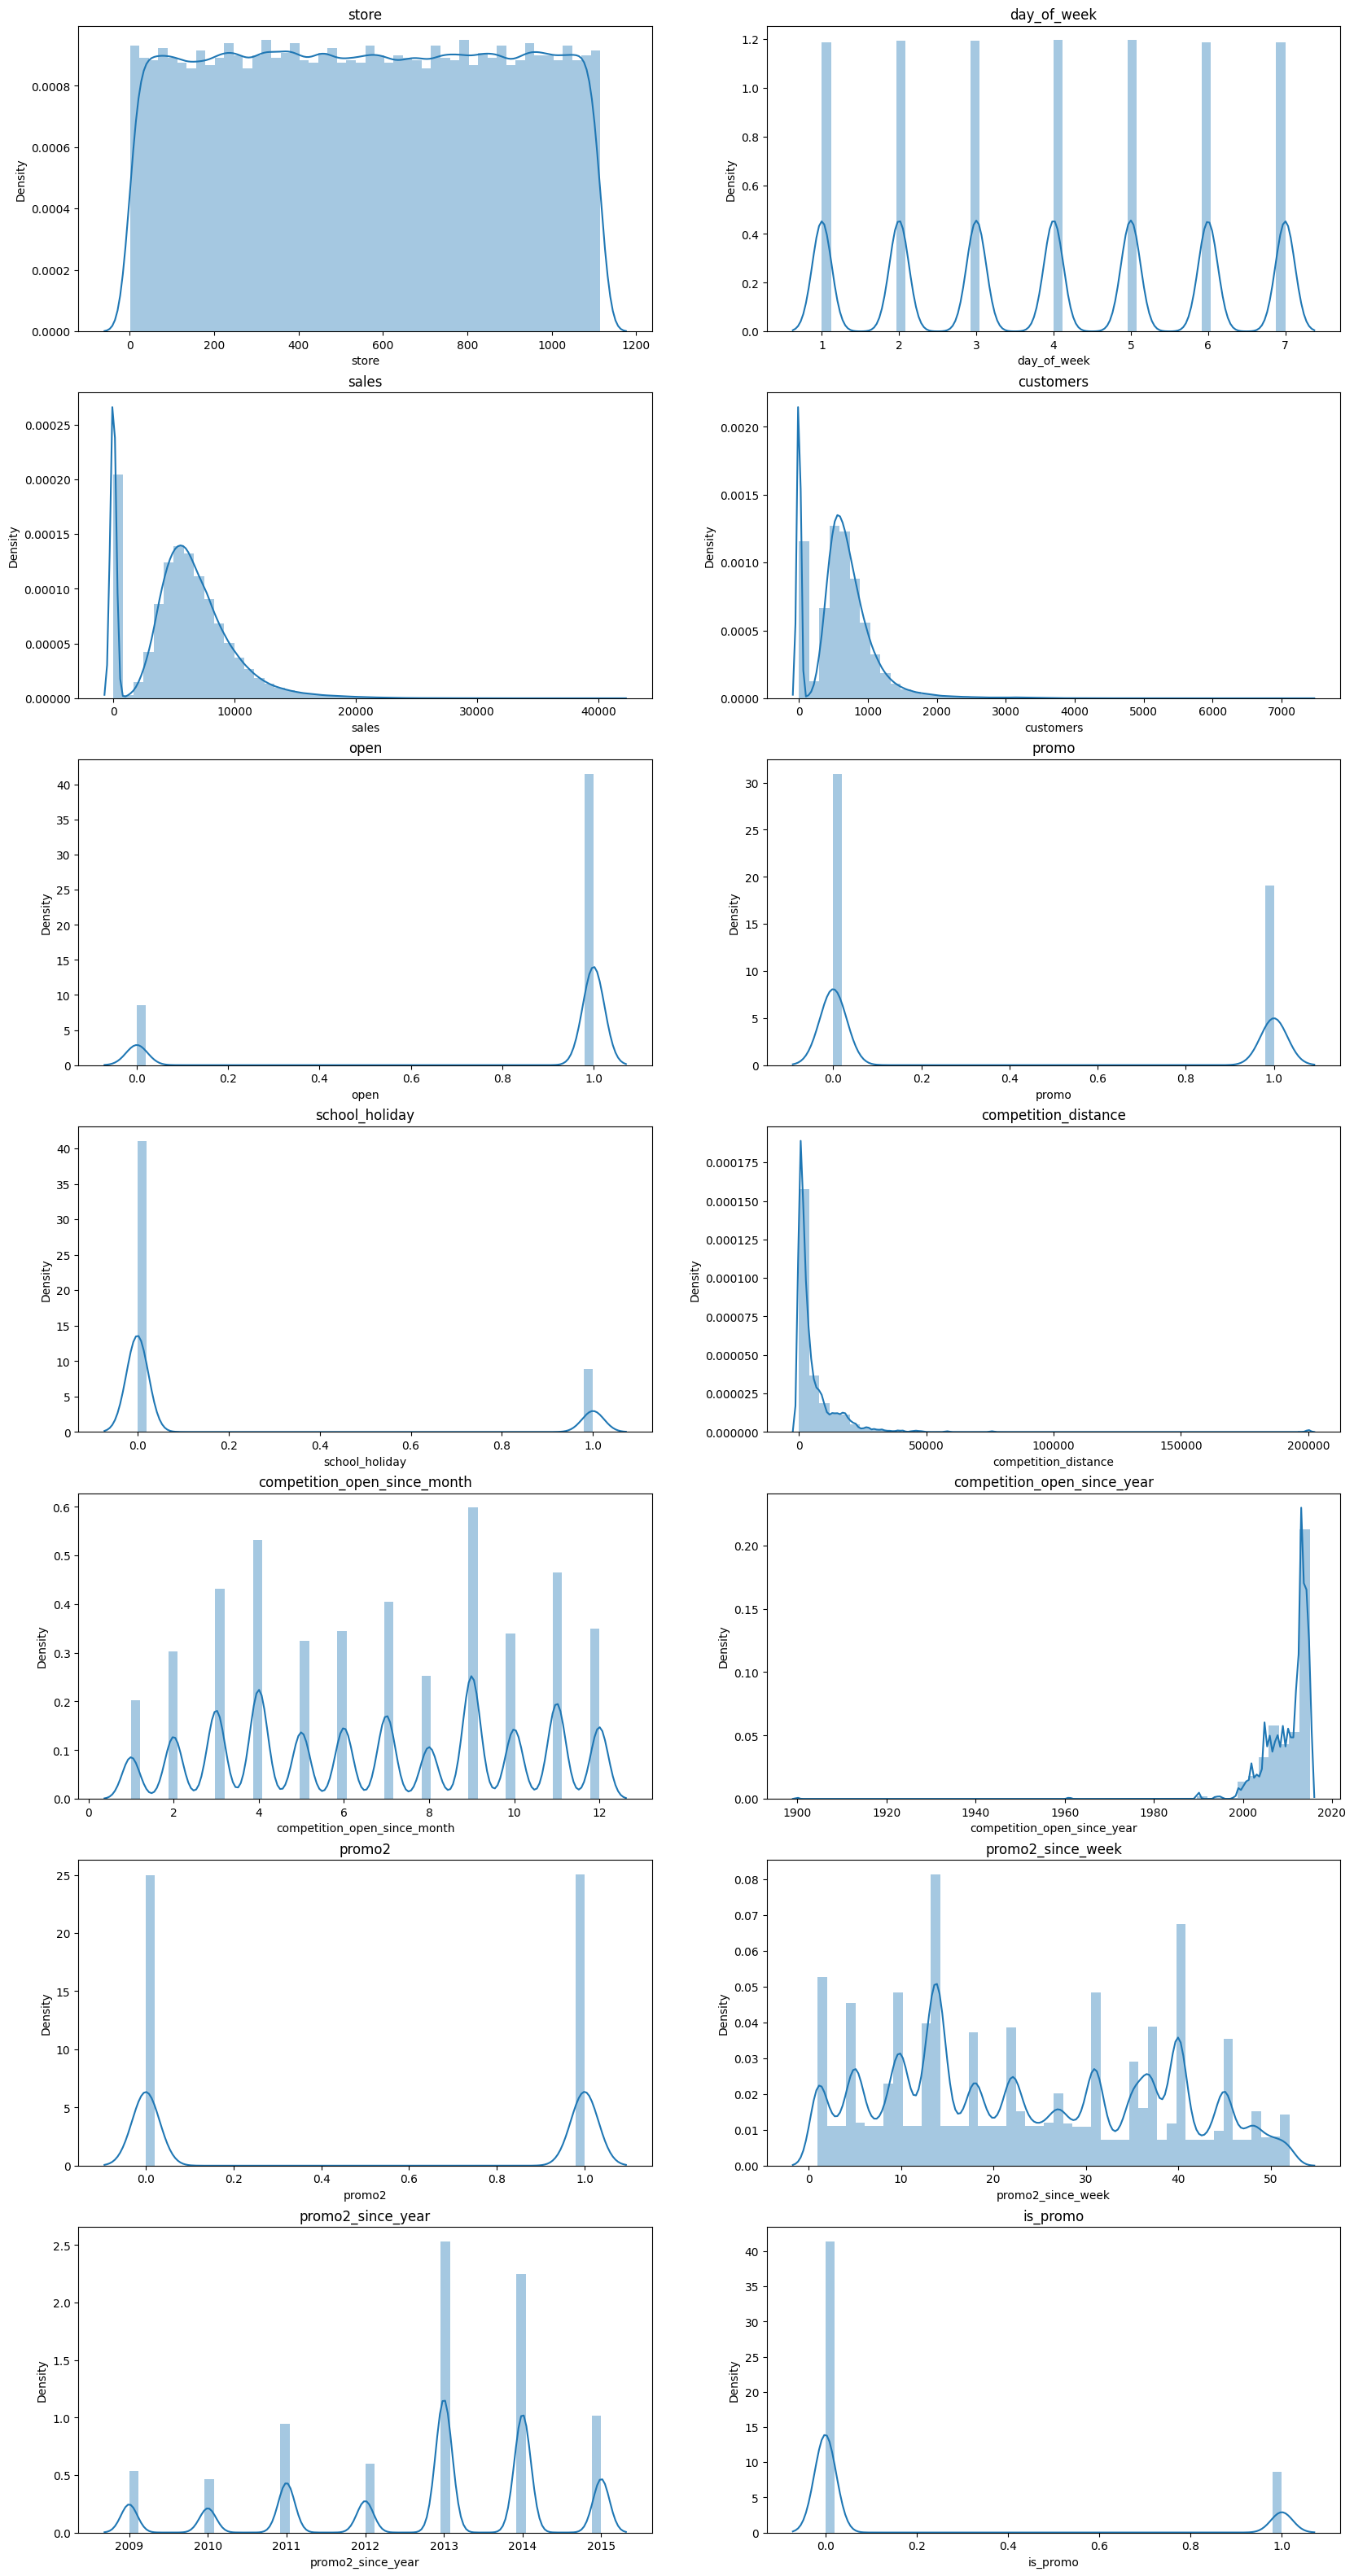

In [29]:
plot_hist(df1)

#### Categorical Attributes

In [30]:
df_cat.nunique()

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot: xlabel='assortment', ylabel='sales'>

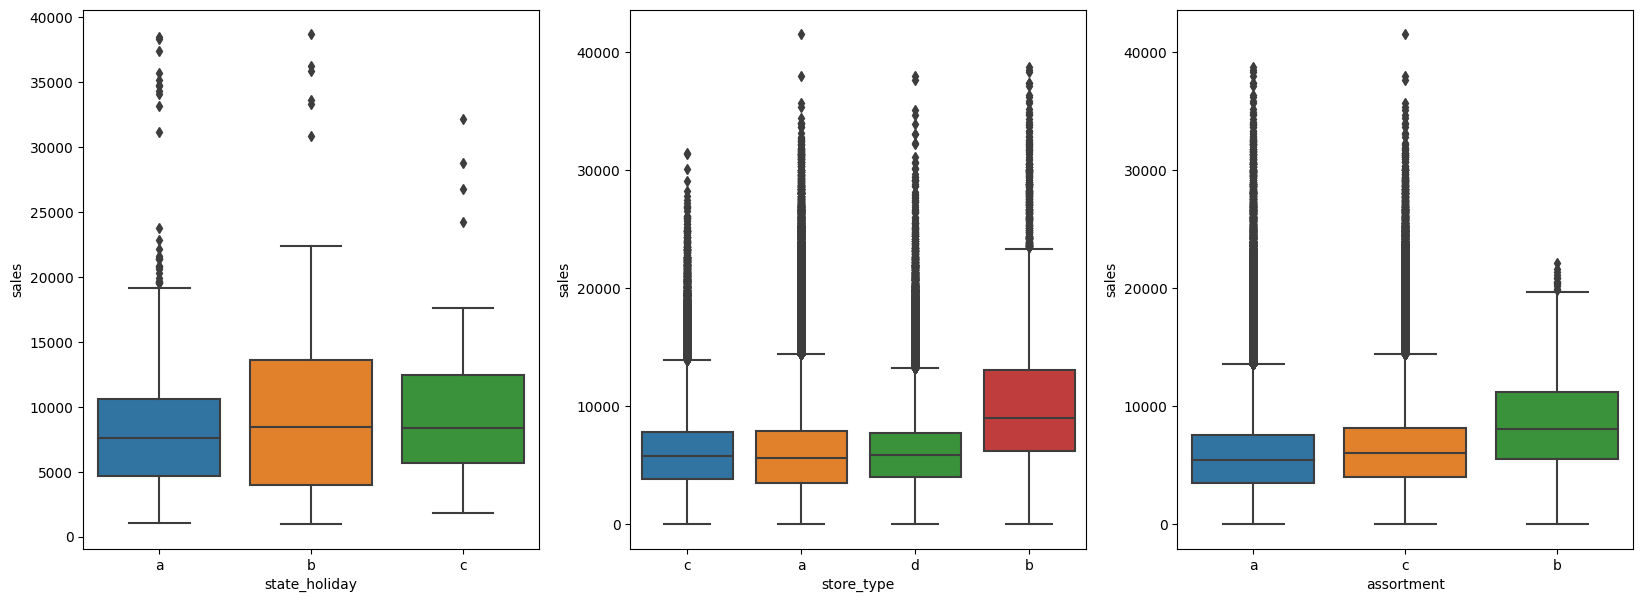

In [31]:
plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
sns.boxplot(x='state_holiday' , y ='sales' , data = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)])

plt.subplot(1,3,2)
sns.boxplot(x='store_type' , y ='sales' , data = df1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment' , y ='sales' , data = df1)

## 4.0 Feature Engineering

In [35]:
df2 = df1.copy()

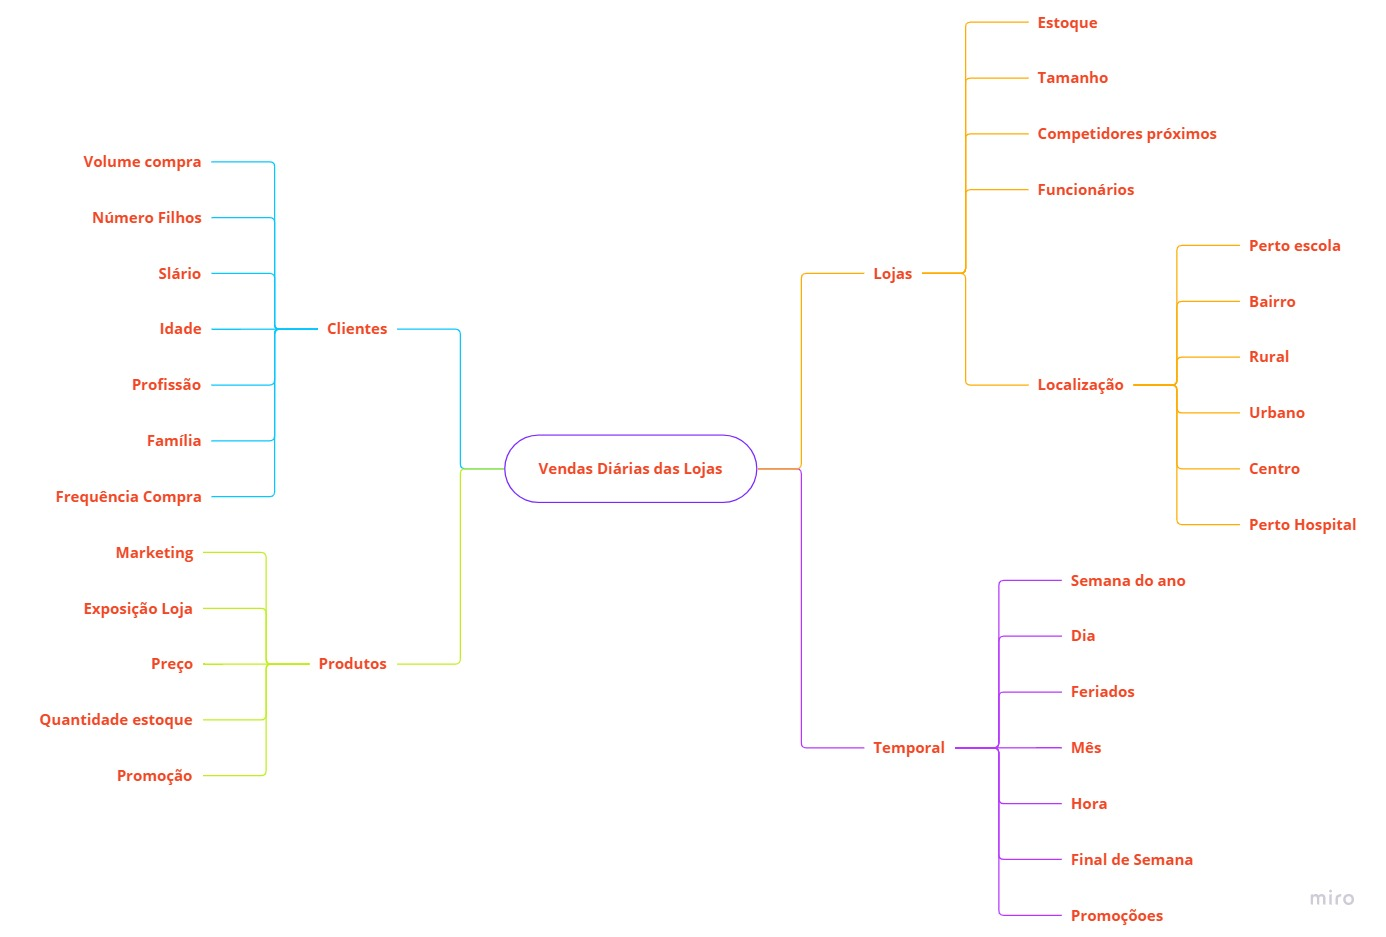

In [34]:
Image('MindMap.jpg')

### 4.1 Criação das Hipóteses

#### 4.1.1 Hipóteses Loja

1. Lojas com número maior de funcionários deveriam vender mais.
2. Lojas com maior capacidade de estoque deveriam vender mais.
3. Lojas com maior porte deveriam vender mais.
4. Lojas com maior sortimentos deveriam vender mais.
5. Lojas com competidores mais próximos deveriam vender menos.
6. Lojas com competidores à mais tempo deveriam vendem mais

#### 4.1.2 Hipóteses Produto

1. Lojas que investem mais em Marketing deveriam vender mais.
2. Lojas com maior exposição de produto deveriam vender mais.
3. Lojas com produtos com preço menor deveriam vender mais.
5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
6. Lojas com promoções ativas por mais tempo deveriam vender mais.
7. Lojas com mais dias de promoção deveriam vender mais.
8. Lojas com mais promoções consecutivas deveriam vender mais.

#### 4.1.3 Hipóteses Tempo

1. Lojas abertas durante o feriado de Natal deveriam vender mais.
2. Lojas deveriam vender mais ao longo dos anos.
3. Lojas deveriam vender mais no segundo semestre do ano.
4. Lojas deveriam vender mais depois do dia 10 de cada mês.
5. Lojas deveriam vender menos aos finais de semana.
6. Lojas deveriam vender menos durante os feriados escolares.


#### 4.1.4 Lista Final de Hipóteses
1. Lojas com maior sortimentos deveriam vender mais.
2. Lojas com competidores mais próximos deveriam vender menos.
3. Lojas com competidores à mais tempo deveriam vendem mais.
4. Lojas com promoções ativas por mais tempo deveriam vender mais.
5. Lojas com mais dias de promoção deveriam vender mais.
7. Lojas com mais promoções consecutivas deveriam vender mais.
8. Lojas abertas durante o feriado de Natal deveriam vender mais.
9. Lojas deveriam vender mais ao longo dos anos.
10. Lojas deveriam vender mais no segundo semestre do ano.
11. Lojas deveriam vender mais depois do dia 10 de cada mês.
12. Lojas deveriam vender menos aos finais de semana.
13. Lojas deveriam vender menos durante os feriados escolares.

### 4.2 Criação das variáveis

In [37]:
df2.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo'],
      dtype='object')

In [75]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# Competition since
# Vamos juntar o mês e o ano e considerar o dia 1 de todo mês como abertura do competidor
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day =1 ), axis = 1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype('int64')

# promo since
# Concatena os valores da semana e ano desde a promoção e concatena com '-1' 
# (que será o dia da semana dentro do formato que estabelacemos sendo 0: domingo, 1: segunda e etc.) 
# para formar o formato de data completo porém para concatenar tem que converter para string e o formato final fica string
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str) + str('-1')
# Aplica a função strptime que transforma uma string em data apenas passando dentro dela a string e o formato de data que a string está 
# e tiramos uma semana da data final
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x , '%Y-%W-%w') - datetime.timedelta(days = 7))
# Calculamos em semana o tempo que a promoção está rolando
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

C:\Users\User\AppData\Local\Temp\ipykernel_2880\579681275.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [74]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a
